In [2]:
import numpy as np
import torch
import torch.nn as nn
import collections
import matplotlib.pyplot as plt

from source_files.storage import RolloutStorage
from source_files.dvrl import DVRL
from source_files.networks import VRNN_encoding, VRNN_proposal, VRNN_deterministic_transition, VRNN_transition, \
    VRNN_emission
from source_files.policy import Categorical
from source_files.wrapper_tiger import TigerEnv
from source_files.utils import toOneHot


def setupExperiment(config):
    env = TigerEnv()
    actionDim = config["actionDim"]
    observationDim = config["observationDim"]

    encodingNetwork = VRNN_encoding(observationDim, config["hiddenDim"],
                                    config["observationEncodeDim"], actionDim, config["actionEncodeDim"])
    proposalNetwork = VRNN_proposal(config["zDim"], config["hDim"], config["observationEncodeDim"],
                                    config["actionEncodeDim"])
    deterministicTransitionNetwork = VRNN_deterministic_transition(config["zDim"], config["observationEncodeDim"],
                                                                   config["hDim"],
                                                                   config["actionEncodeDim"])
    transitionNetwork = VRNN_transition(config["hDim"], config["zDim"], config["actionEncodeDim"])
    emissionNetwork = VRNN_emission(config["hDim"], config["actionEncodeDim"], config["hiddenDim"], observationDim,
                                    config["observationEncodeDim"])

    particleGru = nn.GRU(config["hDim"] * 2 + 1, config["hDim"], batch_first=True)

    criticLinear = nn.Linear(config["hDim"], 1)

    actionDist = Categorical(config["hDim"], actionDim)

    actorCritic = DVRL(actionDim,
                       observationDim,
                       config["actionEncodeDim"],
                       config["observationEncodeDim"],
                       config["hiddenDim"],
                       config["hDim"],
                       config["zDim"],
                       config["numParticles"],
                       encodingNetwork,
                       proposalNetwork,
                       deterministicTransitionNetwork,
                       transitionNetwork,
                       emissionNetwork,
                       particleGru,
                       criticLinear,
                       actionDist)

    # initialize rolloutstorage
    rolloutStorage = RolloutStorage(config["numStepBeforeTrain"])

    # initialize current_memory
    initialState = env.getInitialState()
    obs = np.array([2])

    currentObs = torch.from_numpy(obs).float().unsqueeze(0)

    initStates = actorCritic.newLatentState()
    initRewards = torch.zeros(1, 1)
    initActions = torch.zeros(1, 1)
    currentMemory = {
        'currentObs': currentObs,
        'states': initStates,
        'oneHotActions': toOneHot(
            actionDim,
            initActions),
        'rewards': initRewards,
        'transitionState': initialState
    }
    return env, actorCritic, rolloutStorage, currentMemory


def updateMemory(config, actorCritic, currentMemory, policyReturn, obs, reward, done, transitionState):
    # Make reward into tensor so we can use it as input to model
    reward = torch.from_numpy(np.expand_dims(np.stack(np.array([reward])), 1)).float()
    # If trajectory ended, create mask to clean reset actions and latent states
    masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in [done]])

    # Update current_memory
    currentMemory['currentObs'] = torch.from_numpy(np.array([obs])).float()
    # Create new latent states for new episodes
    # only create new latent state if one episode is done
    currentMemory['states'] = policyReturn.latentState if not done else actorCritic.newLatentState()
    # Set first action to 0 for new episodes
    # Also, if action is discrete, convert it to one-hot vector
    currentMemory['oneHotActions'] = toOneHot(config["actionDim"], policyReturn.action * masks.type(policyReturn.action.type()))
    currentMemory['rewards'][:] = reward
    currentMemory['transitionState'] = transitionState

    return currentMemory, masks, reward


def runOneTimeStep(config, actorCritic, currentMemory, env, cumulativeReward, episode_step):
    # use policy to get action and other stuff
    policyReturn = actorCritic(currentMemory)
    actions = policyReturn.action.detach().squeeze(1).numpy()[0]
    if episode_step <= 4:
        actions = 2
    nextState = env.transition(currentMemory['transitionState'], actions)
    nextObservation = [env.observation(nextState, actions)]
    reward = env.reward(currentMemory['transitionState'], actions, nextState)
    done = env.isterminal("nextState")
    cumulativeReward += reward
    episode_step += 1

    if done:
        nextState = env.getInitialState()
        nextObservation = [2]
        print("episode reward: {}".format(cumulativeReward))

        episode_step = 0

    currentMemory, masks, reward = updateMemory(config, actorCritic, currentMemory, policyReturn, nextObservation, reward,
                                                done, nextState)

    return policyReturn, currentMemory, masks, reward, cumulativeReward, episode_step, done


def trackValues(trackedValues, policyReturn):
    # track value to calculate loss with respect to targets

    trackedValues['values'].append(policyReturn.valueEstimate)
    trackedValues['actionLogProbs'].append(policyReturn.actionLogProbs)
    trackedValues['distEntropy'].append(policyReturn.distEntropy)
    # For loss function
    trackedValues['totalEncodingLoss'].append(policyReturn.totalEncodingLoss)

    return trackedValues


def main():
    config = {"actionEncodeDim": 64,
              "observationEncodeDim": 128,
              "hiddenDim": 64,
              "hDim": 256,
              "zDim": 256,
              "numParticles": 15,
              "numStepBeforeTrain": 4,
              "totalTrainStep": 1000,
              "actionDim": 3,
              "observationDim": 1
              }

    env, actorCritic, rollouts, currentMemory = setupExperiment(config)
    cumulativeReward = 0
    episode_step = 0
    movingAverageReward = []
    scores = collections.deque(maxlen=50)
    # start running
    for j in range(config["totalTrainStep"]):
        trackedValues = collections.defaultdict(lambda: [])
        
        for step in range(config["numStepBeforeTrain"]):
            policyReturn, currentMemory, masks, reward, cumulativeReward, episode_step, done = runOneTimeStep(config,
                actorCritic, \
                currentMemory, env, cumulativeReward, episode_step)

            # save reward for plotting
            if done:
                scores.append(cumulativeReward)
                movingAverageReward.append(np.mean(scores))
                cumulativeReward = 0
            # Save in rollouts (for loss computation)
            rollouts.insert(step, reward, masks)

            # Track all bunch of stuff and also save intermediate images and stuff
            trackedValues = trackValues(trackedValues, policyReturn)

        actorCritic.learn(rollouts, trackedValues, currentMemory)

    #plt.plot(movingAverageReward)
    #plt.show()
    
    return movingAverageReward


if __name__ == '__main__':
    main()

['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
episode reward: 2
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
episode reward: 5
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
episode reward: -105
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
episode reward: 5
[

In [3]:
import pandas as pd

numParticles = [10, 15, 20]
hiddenDim = [64, 128, 256]
Dim = [64, 128, 256]
actionEncodeDim = 64
observationEncodeDim = 128
#actionEncodeDim = [64, 128, 256]
#observationEncodeDim = [64, 128, 256]

#original totalTrainStep: 10000
config = {"actionEncodeDim": 64,
          "observationEncodeDim": 128,
          "hiddenDim": 64,
          "hDim": 256,  # =zDim for VAE
          "zDim": 256,
          "numParticles": 15,
          "numStepBeforeTrain": 4,
          "totalTrainStep": 1000,
          "actionDim": 3,  # fixed
          "observationDim": 1 #fixed
          }

def run_model(numParticles, hiddenDim, Dim, actionEncodeDim, observationEncodeDim):
    config['numParticles'] = numParticles
    config['hiddenDim'] = hiddenDim
    config['hDim'] = config['zDim'] = Dim
    config['actionEncodeDim'] = actionEncodeDim
    config['observationEncodeDim'] = observationEncodeDim
    
    env, actorCritic, rollouts, currentMemory = setupExperiment(config)
    cumulativeReward = 0
    episode_step = 0
    movingAverageReward = []
    scores = collections.deque(maxlen=50)
    for j in range(config["totalTrainStep"]):
        trackedValues = collections.defaultdict(lambda: [])
        for step in range(config["numStepBeforeTrain"]):
            policyReturn, currentMemory, masks, reward, cumulativeReward, episode_step, done = runOneTimeStep(config,
                                                                                                              actorCritic,
                                                                                                              currentMemory,
                                                                                                              env,
                                                                                                              cumulativeReward,
                                                                                                              episode_step)
            if done:
                scores.append(cumulativeReward)
                movingAverageReward.append(np.mean(scores))
                cumulativeReward = 0
            rollouts.insert(step, reward, masks)
            trackedValues = trackValues(trackedValues, policyReturn)
        actorCritic.learn(rollouts, trackedValues, currentMemory)
    return movingAverageReward

def drawLinePlot(val, numParticles, Dim): 
    for i in hiddenDim: 
        plt.plot(val[(numParticles, i, Dim)], label = 'hiddenDim:{}'.format(i))
        plt.legend()

def main():
    levelValues = [numParticles, hiddenDim, Dim]
    levelNames = ['numParticles', 'hiddenDim', 'hDim & zDim']
    ind = pd.MultiIndex.from_product(levelValues, names=levelNames)
    y = {}
    #data = pd.DataFrame(index=ind, columns=['scores'])
    for i in ind:
        y[i] = run_model(*i, actionEncodeDim, observationEncodeDim)
        #data.loc[i] = [y[i]]
        
    fig = plt.figure(figsize = (30, 25))
    plotRowNum = len(numParticles)
    plotColNum = len(Dim)
    plotCounter = 1
    
    for i in numParticles: 
        for j in Dim: 
            ax = fig.add_subplot(plotRowNum, plotColNum, plotCounter)
            drawLinePlot(y, i, j)
            plotCounter += 1
            plt.title('hDim = zDim = ' + str(j))
            plt.ylabel('numParticles ' + str(i))
plt.suptitle('Model Evaluation for DVRL_tiger') 
plt.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
main()

['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
episode reward: 5
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
episode reward: -106
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
episode reward: 3
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
['observation']
['z']
['z']
episode reward: -10

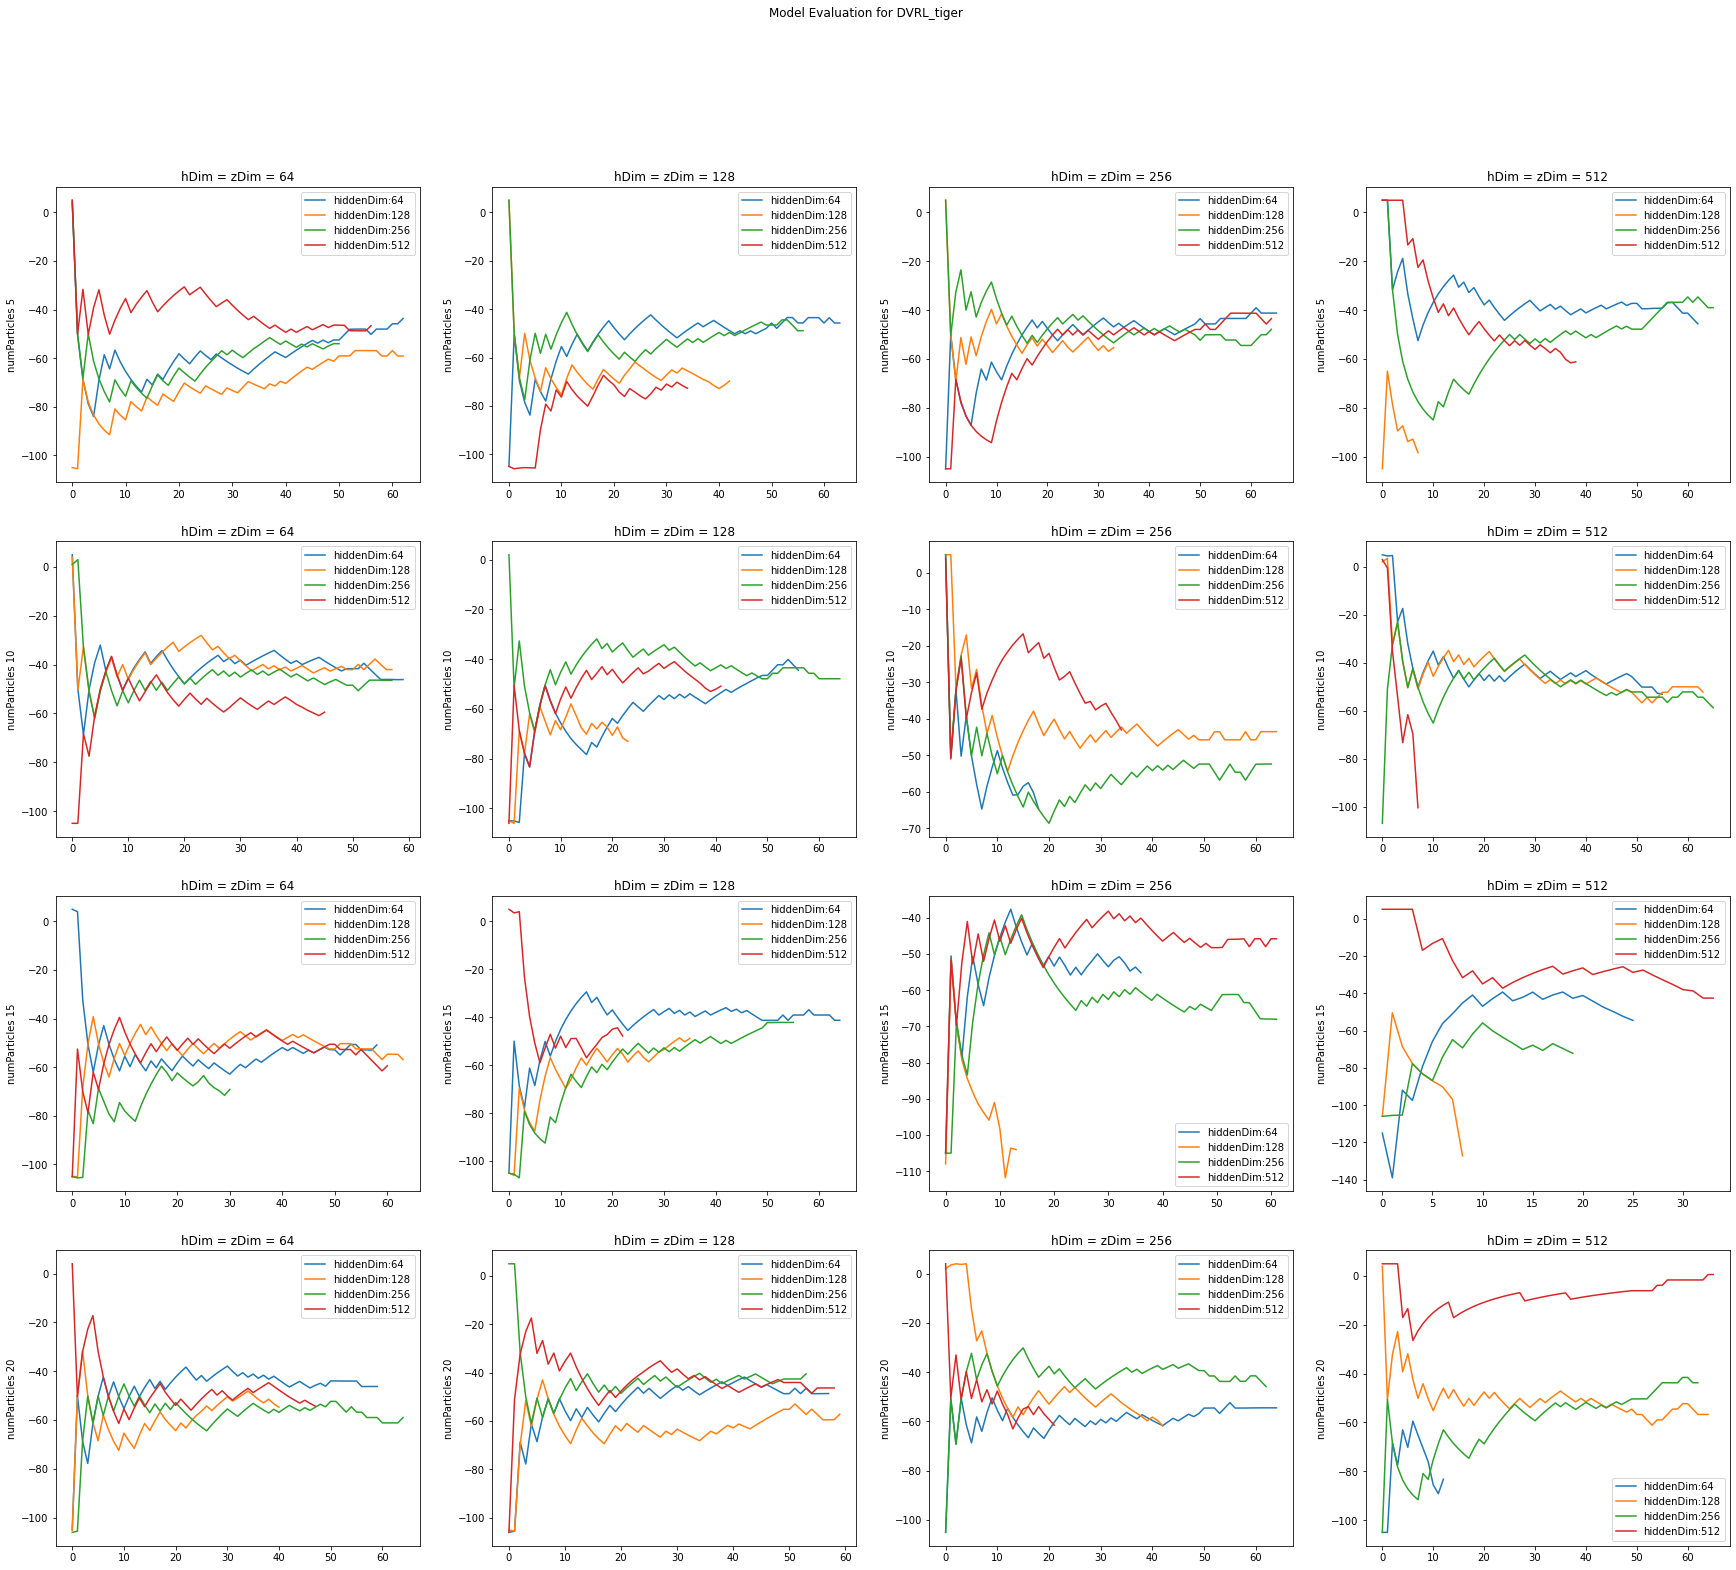

In [207]:
fig = plt.figure(figsize = (30, 25))
plotRowNum = len(numParticles)
plotColNum = len(Dim)
plotCounter = 1
for i in numParticles: 
    for j in Dim: 
        ax = fig.add_subplot(plotRowNum, plotColNum, plotCounter)
        drawLinePlot(i, j)
        plotCounter += 1
        plt.title('hDim = zDim = ' + str(j))
        plt.ylabel('numParticles ' + str(i))
plt.suptitle('Model Evaluation for DVRL_tiger') 
plt.show()   

nP 10 actionEncodeDim 64
nP 10 actionEncodeDim 128
nP 10 actionEncodeDim 256
nP 15 actionEncodeDim 64
nP 15 actionEncodeDim 128
nP 15 actionEncodeDim 256
nP 20 actionEncodeDim 64
nP 20 actionEncodeDim 128
nP 20 actionEncodeDim 256


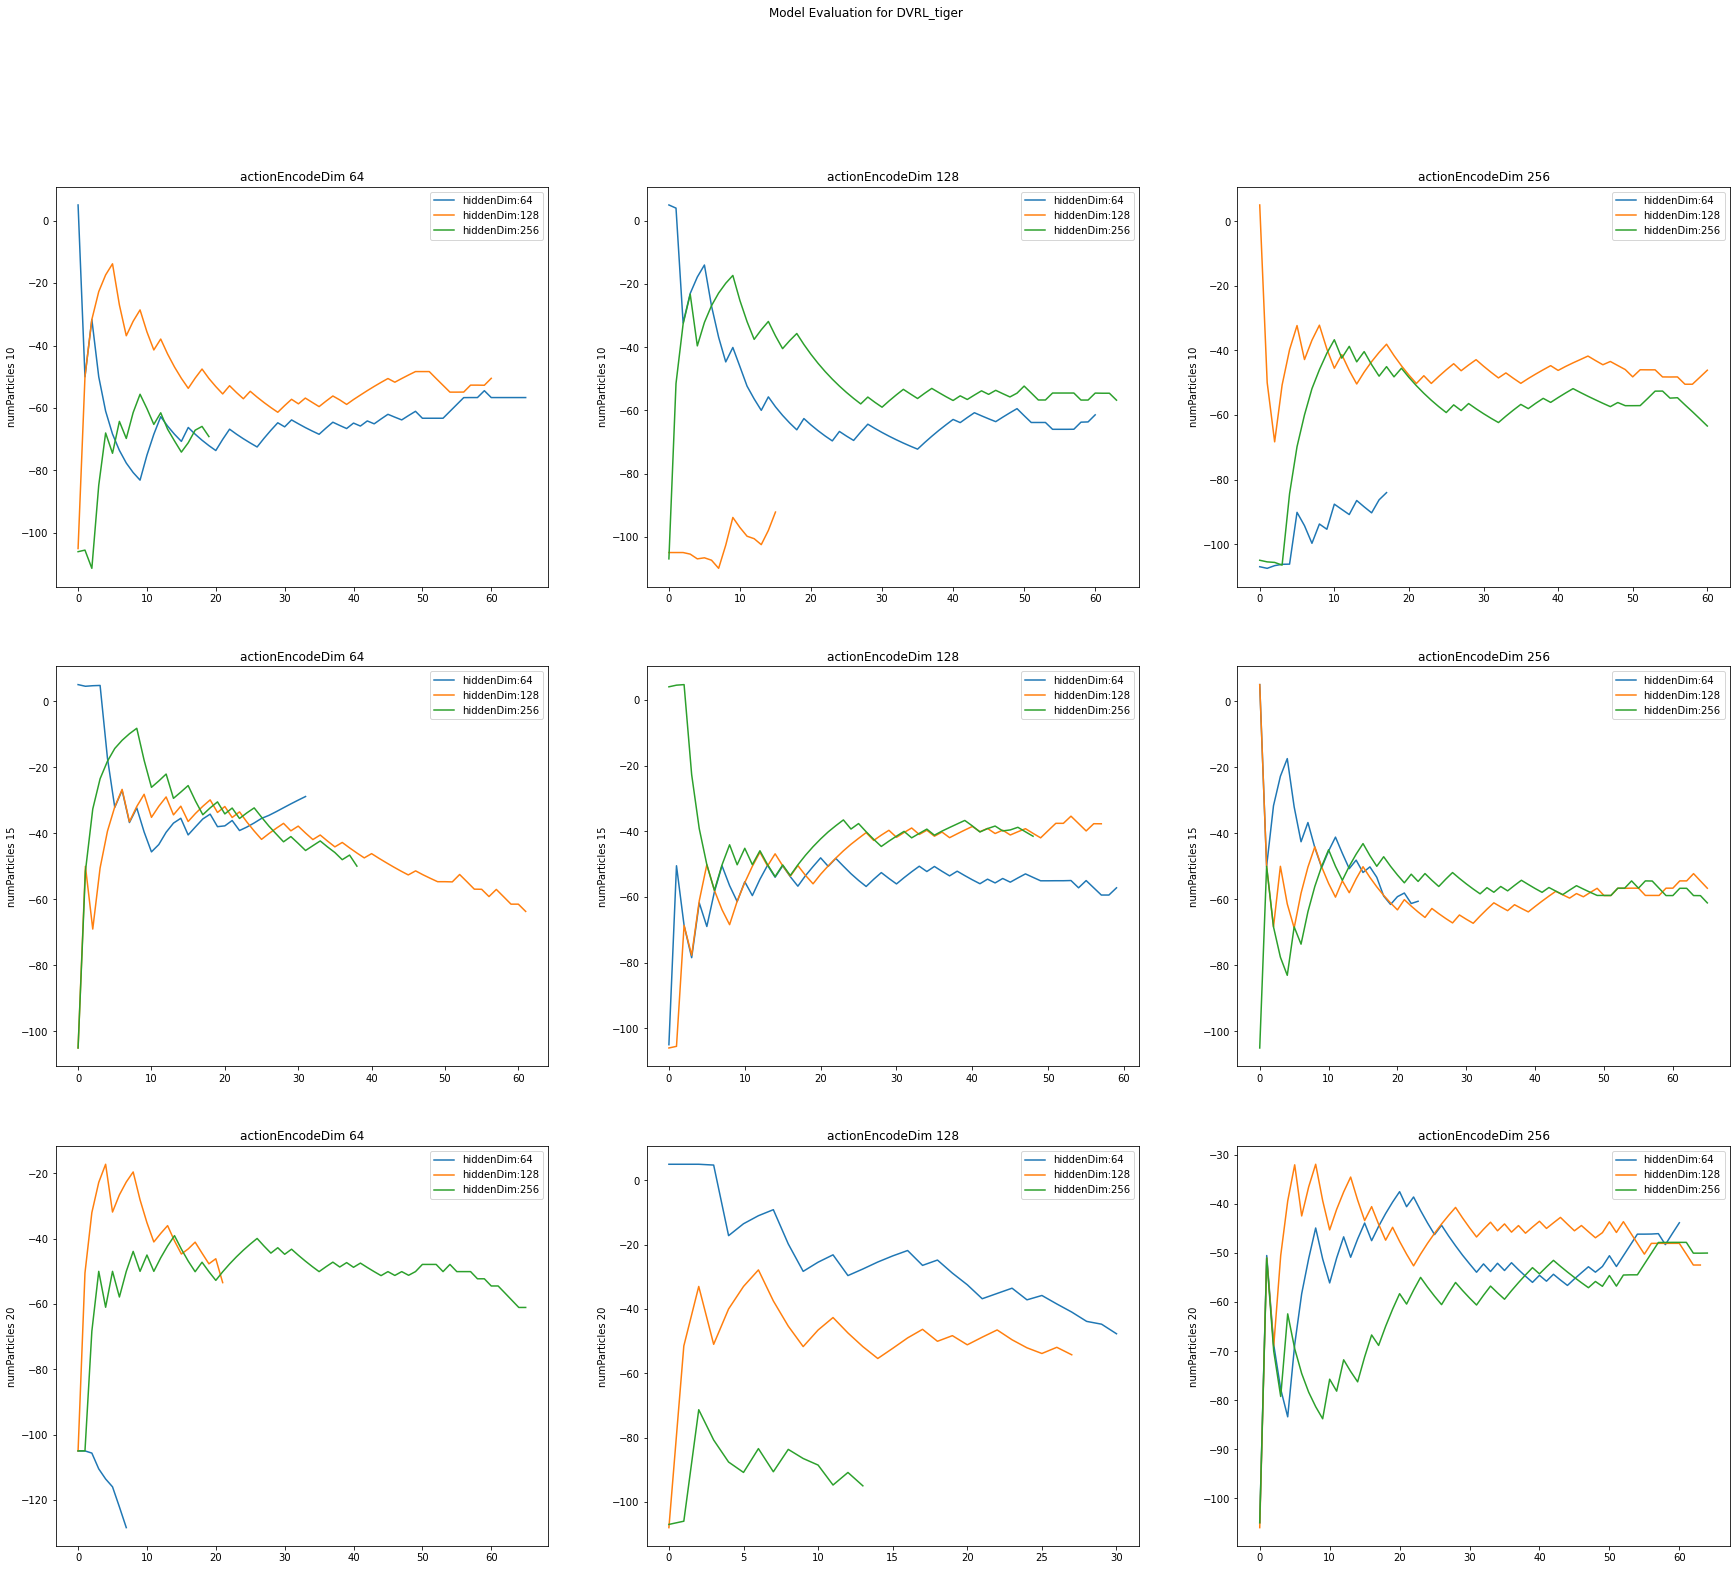

In [196]:
fig = plt.figure(figsize = (30, 25))

def drawLinePlot(numParticles, actionEncodeDim): 
    for i in hiddenDim: 
        plt.plot(y[(numParticles, i, actionEncodeDim, 128)], label = 'hiddenDim:{}'.format(i))
        plt.legend()

plotCounter = 1
for i in numParticles: 
    for j in actionEncodeDim: 
        ax = fig.add_subplot(3, 3, plotCounter)
        drawLinePlot(i, j)
        plotCounter += 1
        plt.title('actionEncodeDim ' + str(j))
        plt.ylabel('numParticles ' + str(i))
plt.suptitle('Model Evaluation for DVRL_tiger') 
plt.show()